# Beiwe Sample Dataset Accelerometer EDA Pt. 2

Prototype helper functions to load and summarize an hour's worth of accelerometer data 


In [13]:
%load_ext autoreload
%autoreload 2 

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# TODO: move to its own script
def summarize_hourly_file(file_path, verbose=True):
    """Analyze a single hourly accelerometer CSV file."""
    try:
        # Check if file exists
        if not os.path.exists(file_path):
            if verbose:
                print(f"Missing: {os.path.basename(file_path)}")
            return None
        # If it exists read CSV
        df = pd.read_csv(file_path)
        
        # Handle empty files
        if len(df) == 0:
            if verbose:
                print(f"Empty: {os.path.basename(file_path)}")
            return None
    
    except Exception as e:
        print(f"An unexpected error occurred: {e}")    

    # Convert timestamps
    df['datetime_utc'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)

    # Compute magnitude
    df['magnitude'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)

    # Calculate metrics
    n_rows = len(df)
    start_time = df['datetime_utc'].iloc[0]
    end_time = df['datetime_utc'].iloc[-1]
    
    # Duration in minutes
    duration_sec = (end_time - start_time).total_seconds()
    duration_min = duration_sec / 60
    
    # Sampling time in minutes (at 10 Hz)
    sampling_min = n_rows / 10 / 60
    
    # Duty cycle
    duty_cycle = sampling_min / duration_min
    
    # Count bursts
    df['time_diff_ms'] = df['timestamp'].diff()
    gaps = df['time_diff_ms'] > 1000 
    gaps_count = gaps.sum()
    n_bursts = gaps_count + 1
    
    # Mean magnitude
    mean_magnitude = df['magnitude'].mean()

    return {
        'n_rows': n_rows,
        'start_time': start_time,
        'end_time': end_time,
        'duration_min': duration_min,
        'sampling_min': sampling_min,
        'duty_cycle': duty_cycle,
       'n_bursts': n_bursts,
        'mean_magnitude': mean_magnitude
    }

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Check that summarize_hourly_file() works on the hr_9 CSV 

In [4]:
base_path = "/n/home01/egraff/sample_imputation/data/raw/3si9xdvl/accelerometer/"
test_file_path = base_path + "2022-03-26 09_00_00+00_00.csv"

result = summarize_hourly_file(test_file_path)
print(result)

{'n_rows': 18090, 'start_time': Timestamp('2022-03-26 09:00:38.792000+0000', tz='UTC'), 'end_time': Timestamp('2022-03-26 09:59:39.055000+0000', tz='UTC'), 'duration_min': 59.00438333333333, 'sampling_min': 30.15, 'duty_cycle': 0.5109789865894144, 'n_bursts': np.int64(30), 'mean_magnitude': np.float64(1.0069258994313353)}


Now try on different files 

In [ ]:
test_hours = [0, 9, 16, 23]

print("\n" + "="*79)
for hour in test_hours:
    file_path = base_path + f"2022-03-26 {hour:02d}_00_00+00_00.csv"
    print(f"\nHour {hour:02d}:00")
    print("-" *79)
    
    try:
        result = summarize_hourly_file(file_path)
        
        print(f"Rows: {result['n_rows']:, }")
        print(f"Time span: {result['start_time'].strftime('%H:%M:%S')} to {result['end_time'].strftime('%H:%M:%S')}")
        print(f"Duration: {result['duration_min']:.1f} min")
        print(f"Sampling time: {result['sampling_min']:.1f} min")
        print(f"Duty cycle: {result['duty_cycle']:.1%}")
        print(f"Bursts: {result['n_bursts']}")
        print(f"Mean magnitude: {result['mean_magnitude']:.4f} g")
        
    except FileNotFoundError:
        print(f"File not found")
    except Exception as e:
        print(f"Error: {e}")

print("\n" + "="*79)



Hour 00:00
-------------------------------------------------------------------------------
Error: Cannot specify ',' with '\x20'.

Hour 09:00
-------------------------------------------------------------------------------
Error: Cannot specify ',' with '\x20'.

Hour 16:00
-------------------------------------------------------------------------------
Error: Cannot specify ',' with '\x20'.

Hour 23:00
-------------------------------------------------------------------------------
Error: Cannot specify ',' with '\x20'.



In [6]:
# Read all 24hrs for subject 3si9xdvl on 2022-03-26
date_str = "2022-03-26"
subject_id = "3si9xdvl"

daily_summary = []

for hour in range(24):
    file_path = base_path + f"{date_str} {hour:02d}_00_00+00_00.csv"
    
    result = summarize_hourly_file(file_path)
    
    if result is not None:
        # Add hour and date info
        result['hour'] = hour
        result['date'] = date_str
        result['subject_id'] = subject_id
        daily_summary.append(result)

summary_df = pd.DataFrame(daily_summary)

print(f"Summarized {len(summary_df)} out of 24 hours")
print(f"\n{summary_df.head(10)}")

Missing: 2022-03-26 01_00_00+00_00.csv
Missing: 2022-03-26 02_00_00+00_00.csv
Missing: 2022-03-26 03_00_00+00_00.csv
Missing: 2022-03-26 15_00_00+00_00.csv
Summarized 20 out of 24 hours

   n_rows                       start_time                         end_time  \
0     602 2022-03-26 00:26:29.955000+00:00 2022-03-26 00:27:29.812000+00:00   
1    8620 2022-03-26 04:31:15.460000+00:00 2022-03-26 04:59:33.337000+00:00   
2   11438 2022-03-26 05:00:33.399000+00:00 2022-03-26 05:59:34.726000+00:00   
3   18081 2022-03-26 06:00:34.770000+00:00 2022-03-26 06:59:34.988000+00:00   
4   18100 2022-03-26 07:00:35.057000+00:00 2022-03-26 07:59:37.352000+00:00   
5   18098 2022-03-26 08:00:37.442000+00:00 2022-03-26 08:59:38.720000+00:00   
6   18090 2022-03-26 09:00:38.792000+00:00 2022-03-26 09:59:39.055000+00:00   
7   18088 2022-03-26 10:00:39.127000+00:00 2022-03-26 10:59:39.403000+00:00   
8   18098 2022-03-26 11:00:39.477000+00:00 2022-03-26 11:59:40.737000+00:00   
9   18098 2022-03-26 12

In [7]:
# Want to see all rows
pd.set_option('display.max_rows', None)
print(summary_df)

    n_rows                       start_time                         end_time  \
0      602 2022-03-26 00:26:29.955000+00:00 2022-03-26 00:27:29.812000+00:00   
1     8620 2022-03-26 04:31:15.460000+00:00 2022-03-26 04:59:33.337000+00:00   
2    11438 2022-03-26 05:00:33.399000+00:00 2022-03-26 05:59:34.726000+00:00   
3    18081 2022-03-26 06:00:34.770000+00:00 2022-03-26 06:59:34.988000+00:00   
4    18100 2022-03-26 07:00:35.057000+00:00 2022-03-26 07:59:37.352000+00:00   
5    18098 2022-03-26 08:00:37.442000+00:00 2022-03-26 08:59:38.720000+00:00   
6    18090 2022-03-26 09:00:38.792000+00:00 2022-03-26 09:59:39.055000+00:00   
7    18088 2022-03-26 10:00:39.127000+00:00 2022-03-26 10:59:39.403000+00:00   
8    18098 2022-03-26 11:00:39.477000+00:00 2022-03-26 11:59:40.737000+00:00   
9    18098 2022-03-26 12:00:40.804000+00:00 2022-03-26 12:59:42.082000+00:00   
10   18090 2022-03-26 13:00:42.146000+00:00 2022-03-26 13:59:42.426000+00:00   
11   17487 2022-03-26 14:00:42.494000+00

In [11]:
# duty cycle statistics across available data -- is mostly around 50%, i.e., 1 minute on,1 minute off
print("duty cycle statistics \n", summary_df['duty_cycle'].describe())

print("\nmean magnitude statistics \n", summary_df['mean_magnitude'].describe())

duty cycle statistics 
 count    20.000000
mean      0.526303
std       0.120442
min       0.322986
25%       0.510583
50%       0.510944
75%       0.511059
max       1.005730
Name: duty_cycle, dtype: float64

mean magnitude statistics 
 count    20.000000
mean      1.015477
std       0.019447
min       1.000799
25%       1.006458
50%       1.008045
75%       1.018537
max       1.089120
Name: mean_magnitude, dtype: float64


Max magnitude is 1.089120g (> 1.05g), which suggests walking. This happened at hour 21 (hour 17 i.e., 5pm eastern), maybe when the person was commuting? 


17   18065 2022-03-26 21:00:04.751000+00:00 2022-03-26 21:59:06.030000+00:00

17     59.021317     30.108333    0.510126        31        1.089120    21  

Let's visualize hour 21 and compare to hour 9


Hour 9 (baseline) magnitude statistics:
  Min:  0.9931
  Max:  1.0133
  Mean: 1.0069
  Std:  0.0006
Hour 21 (active) magnitude statistics:
  Min:  0.0178
  Max:  4.2594
  Mean: 1.0891
  Std:  0.4605


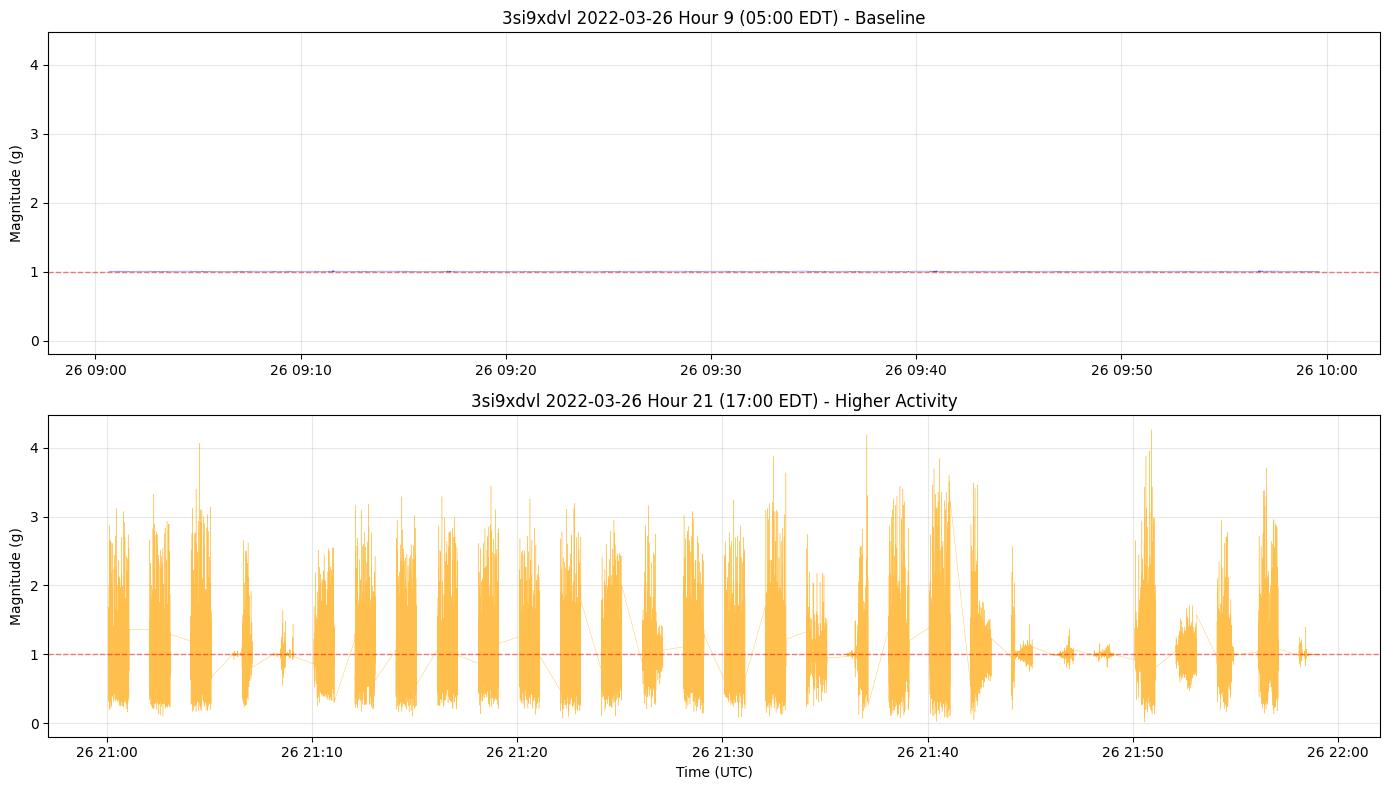

In [25]:
# Get summary stats for both hours
file_path_9 = base_path + "2022-03-26 09_00_00+00_00.csv"
df_9 = pd.read_csv(file_path_9)
df_9['datetime_utc'] = pd.to_datetime(df_9['timestamp'], unit='ms', utc=True)
df_9['magnitude'] = np.sqrt(df_9['x']**2 + df_9['y']**2 + df_9['z']**2)

print(f"\nHour 9 (baseline) magnitude statistics:")
print(f"  Min:  {df_9['magnitude'].min():.4f}")
print(f"  Max:  {df_9['magnitude'].max():.4f}")
print(f"  Mean: {df_9['magnitude'].mean():.4f}")
print(f"  Std:  {df_9['magnitude'].std():.4f}")

file_path_21 = base_path + "2022-03-26 21_00_00+00_00.csv"
df_21 = pd.read_csv(file_path_21)
df_21['datetime_utc'] = pd.to_datetime(df_21['timestamp'], unit='ms', utc=True)
df_21['magnitude'] = np.sqrt(df_21['x']**2 + df_21['y']**2 + df_21['z']**2)

print(f"Hour 21 (active) magnitude statistics:")
print(f"  Min:  {df_21['magnitude'].min():.4f}")
print(f"  Max:  {df_21['magnitude'].max():.4f}")
print(f"  Mean: {df_21['magnitude'].mean():.4f}")
print(f"  Std:  {df_21['magnitude'].std():.4f}")

# set y axis limits
min_mag = min(df_9['magnitude'].min(), df_21['magnitude'].min())
max_mag = max(df_9['magnitude'].max(), df_21['magnitude'].max())
# add padding
y_padding = (max_mag - min_mag) * 0.05
y_min = min_mag - y_padding
y_max = max_mag + y_padding

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=False)

# Hour 9
axes[0].plot(df_9['datetime_utc'], df_9['magnitude'], linewidth=0.3, alpha=0.7, color='blue')
axes[0].axhline(y=1.0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[0].set_ylabel('Magnitude (g)')
axes[0].set_title('3si9xdvl 2022-03-26 Hour 9 (05:00 EDT) - Baseline')
axes[0].set_ylim(y_min, y_max)
axes[0].grid(alpha=0.3)

# Hour 21 
axes[1].plot(df_21['datetime_utc'], df_21['magnitude'], linewidth=0.3, alpha=0.7, color='orange')
axes[1].axhline(y=1.0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Time (UTC)')
axes[1].set_ylabel('Magnitude (g)')
axes[1].set_title('3si9xdvl 2022-03-26 Hour 21 (17:00 EDT) - Higher Activity')
axes[1].set_ylim(y_min, y_max)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Some observations: 
- SD in acc. magnitude for hour 21 is 0.4605g and that of hour 9 is 0.0006, meaning there's ~800-fold change between hour 9 and hour 21. This confirms that the subject was active at hour 21.
- In hour 21, we can still see the minute-on, minute-off sampling patterns. 

In [ ]:
# TODO move to script
def classify_activity(magnitude_series):
    """
    Simple activity classifier based on magnitude variation.
    """
    std = magnitude_series.std()
    
    if std < 0.01:
        return "Stationary"
    elif std < 0.1:
        return "Light movement"
    elif std < 0.3:
        return "Moderate activity"
    else:
        return "High activity"

In [27]:
# Also check other hours with higher mean magnitude to detect possible activity
higher_hrs = [5, 16, 19, 21]

print("=== Higher hours stats ===")
for hour in higher_hrs:
    file_path = base_path + f"2022-03-26 {hour:02d}_00_00+00_00.csv"
    df_temp = pd.read_csv(file_path)
    df_temp['magnitude'] = np.sqrt(df_temp['x']**2 + df_temp['y']**2 + df_temp['z']**2)
    
    print(f"Hour {hour:02d} ({(hour-4)%24:02d}:00 EDT):")
    print(f"  Mean: {df_temp['magnitude'].mean():.4f} g")
    print(f"  Std:  {df_temp['magnitude'].std():.4f} g")

=== Higher hours stats ===
Hour 05 (01:00 EDT):
  Mean: 1.0270 g
  Std:  0.1722 g
Hour 16 (12:00 EDT):
  Mean: 1.0340 g
  Std:  0.2509 g
Hour 19 (15:00 EDT):
  Mean: 1.0240 g
  Std:  0.2533 g
Hour 21 (17:00 EDT):
  Mean: 1.0891 g
  Std:  0.4605 g


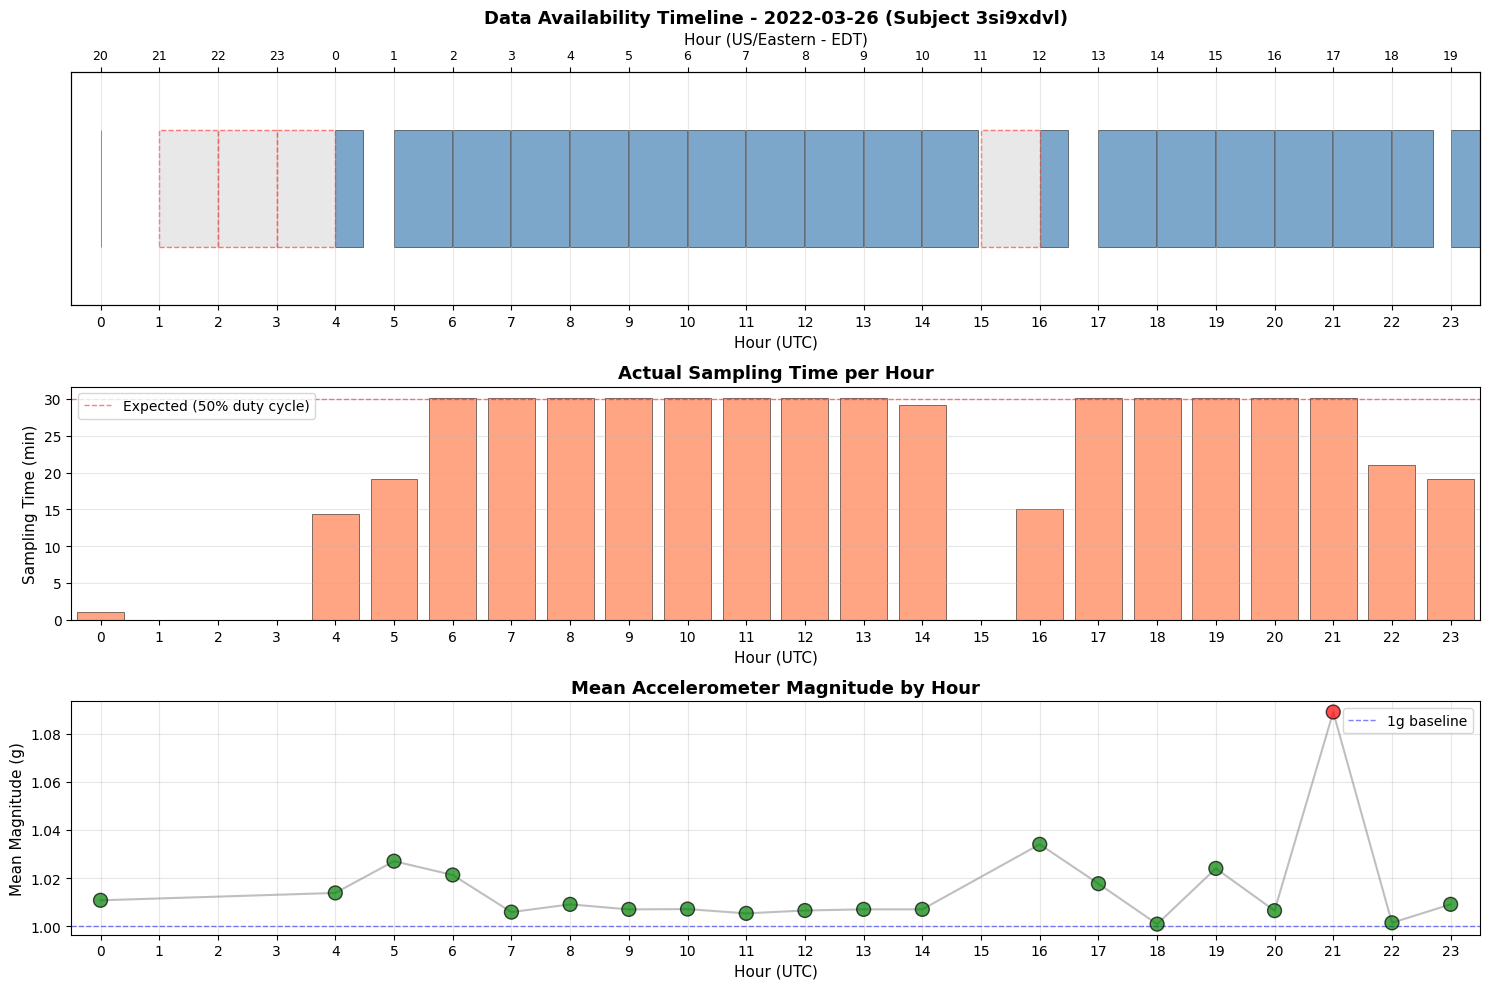

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Data existence by hour
ax = axes[0]

for _, row in summary_df.iterrows():
    ax.barh(y=0, width=row['duration_min']/60, left=row['hour'], 
            height=0.5, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)

# Mark missing hours
all_hours = set(range(24))
present_hours = set(summary_df['hour'].values)
missing_hours = sorted(all_hours - present_hours)

for h in missing_hours:
    ax.barh(y=0, width=1, left=h, height=0.5, color='lightgray', 
            alpha=0.5, edgecolor='red', linewidth=1, linestyle='--')

ax.set_xlim(-0.5, 23.5)
ax.set_ylim(-0.5, 0.5)
ax.set_xlabel('Hour (UTC)', fontsize=11)
ax.set_title('Data Availability Timeline - 2022-03-26 (Subject 3si9xdvl)', 
             fontsize=13, fontweight='bold')
ax.set_yticks([])
ax.set_xticks(range(24))
ax.grid(axis='x', alpha=0.3)

# Eastern time on top
# TODO convert all to EDT
ax2 = ax.twiny()
ax2.set_xlim(-0.5, 23.5)
ax2.set_xticks(range(24))
ax2.set_xticklabels([(h-4)%24 for h in range(24)], fontsize=9)
ax2.set_xlabel('Hour (US/Eastern - EDT)', fontsize=11)

# Actual sampling time  
ax = axes[1]

ax.bar(summary_df['hour'], summary_df['sampling_min'], 
       color='coral', alpha=0.7, edgecolor='black', linewidth=0.5, width=0.8)
ax.set_xlim(-0.5, 23.5)
ax.set_xlabel('Hour (UTC)', fontsize=11)
ax.set_ylabel('Sampling Time (min)', fontsize=11)
ax.set_title('Actual Sampling Time per Hour', fontsize=13, fontweight='bold')
ax.axhline(y=30, color='red', linestyle='--', linewidth=1, alpha=0.5, 
           label='Expected (50% duty cycle)')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_xticks(range(24))

# Mean Magnitude
ax = axes[2]

colors = ['red' if mag > 1.05 else 'green' for mag in summary_df['mean_magnitude']]
ax.scatter(summary_df['hour'], summary_df['mean_magnitude'], 
          s=100, c=colors, alpha=0.7, edgecolor='black', linewidth=1, zorder=3)
ax.plot(summary_df['hour'], summary_df['mean_magnitude'], 
        linewidth=1.5, color='gray', alpha=0.5, zorder=2)

# TODO add mild, moderate, high activity colors and legend
ax.set_xlim(-0.5, 23.5)
ax.set_xlabel('Hour (UTC)', fontsize=11)
ax.set_ylabel('Mean Magnitude (g)', fontsize=11)
ax.set_title('Mean Accelerometer Magnitude by Hour', fontsize=13, fontweight='bold')
ax.axhline(y=1.0, color='blue', linestyle='--', linewidth=1, alpha=0.5, label='1g baseline')
ax.legend()
ax.grid(alpha=0.3)
ax.set_xticks(range(24))

plt.tight_layout()
plt.show()

## Bookmark 25-10-10 
### TODO: 
#  - Take care of TODOs in the cell
#  - Read in data from multiple days and subjects (with EDT column and data present indicator), save as intermediate results
# - mini goal: Visualize indicators at the hourly, daily, and weekly level for fixed subject